## Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cx_Oracle
from sklearn import preprocessing
import scipy as sp
from sklearn.cluster import KMeans

## Data Prep

In [222]:
########### Reading Data set ############################################################
covid=pd.read_csv(r"C:\Users\TCOSDEMIR\Desktop\Digital Masters\covid-tests-cases-deaths.csv")

In [231]:
########### Data Type Tuning & filling N/A ############################################################
covid.Date=pd.to_datetime(covid.Date)

covid.Death.fillna(0,inplace=True)
covid.Death=covid.Death.astype("int")

covid.Case.fillna(0,inplace=True)
covid.Case=covid.Case.astype("int")

covid.GDP=pd.DataFrame(covid.GDP).astype("int64")
covid.Population=pd.DataFrame(covid.Population).astype("int64")

,Country,Date,Test,Death,Case,GDP,Population
0,Afghanistan,2019-12-31,NaN,0,0,21969414112,38928000
1,Afghanistan,2020-01-01,NaN,0,0,21969414112,38928000
2,Afghanistan,2020-01-02,NaN,0,0,21969414112,38928000
3,Afghanistan,2020-01-03,NaN,0,0,21969414112,38928000
4,Afghanistan,2020-01-04,NaN,0,0,21969414112,38928000
...,...,...,...,...,...,...,...
9885,Zimbabwe,2020-04-10,NaN,3,11,15329810786,14863000
9886,Zimbabwe,2020-04-11,NaN,3,11,15329810786,14863000
9887,Zimbabwe,2020-04-12,NaN,3,14,15329810786,14863000
9888,Zimbabwe,2020-04-13,NaN,3,14,15329810786,14863000


## Analyze the data

C:\Users\TCOSDEMIR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



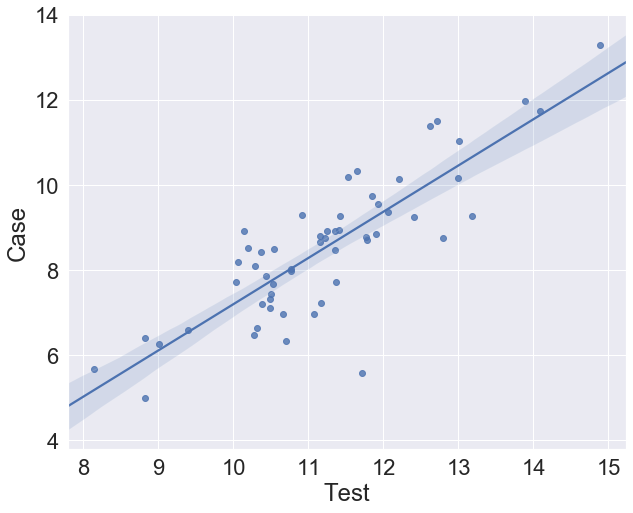

In [226]:
###### Test numbers & Case Correlation ###########################
covid_corr=covid.groupby("Country").max().reset_index().dropna()
covid_corr[["Test","Death","Case","GDP","Population"]]=np.log(covid_corr[["Test","Death","Case","GDP","Population"]])

sns.set(font_scale = 2)
plt.figure(figsize=(10,8))
ax = sns.regplot(x="Test", y="Case", data=covid_corr)


In [227]:
# Correlaiton coefficient btw metrics
covid.groupby("Country").max().reset_index().dropna().corr()

,Test,Death,Case,GDP,Population
Test,1.000000,0.773882,0.955091,0.891133,0.212584
Death,0.773882,1.000000,0.844117,0.715461,0.123705
Case,0.955091,0.844117,1.000000,0.922433,0.185383
GDP,0.891133,0.715461,0.922433,1.000000,0.317326
Population,0.212584,0.123705,0.185383,0.317326,1.000000


## Imputation

In [228]:
# It shows us there is strong correlation between test & case, so we can impute N/A test metrics

# We need to found a ratio for every country related to case
df=covid.groupby("Country").max().reset_index().dropna()
ratio=pd.DataFrame()
ratio["Country"]=df.Country
ratio["ratio"]=df.Case/df.Test

# Now we can impute tihs ratio to every day country by country
covid_new=covid.merge(ratio,on="Country",how="inner")
covid_new.Test[covid_new.Test.isna()]=covid_new.Case[covid_new.Test.isna()]/covid_new.ratio[covid_new.Test.isna()]

# Adding GDP per capita 
covid_new["GDP_per_capita"]=(covid_new.GDP/covid_new.Population).astype("int")

# Adding Test per GDP

covid_new["Test_perf"]=covid_new.Test/covid_new.GDP_per_capita
covid_new

C:\Users\TCOSDEMIR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country,Date,Test,Death,Case,GDP,Population,ratio,GDP_per_capita,Test_perf
0,Argentina,2020-03-04,10.037412,0,1,460334000000,45196000,0.099627,10185,0.000986
1,Argentina,2020-03-06,20.074824,0,2,460334000000,45196000,0.099627,10185,0.001971
2,Argentina,2020-03-07,80.299296,0,8,460334000000,45196000,0.099627,10185,0.007884
3,Argentina,2020-03-08,90.336708,1,9,460334000000,45196000,0.099627,10185,0.008870
4,Argentina,2020-03-09,120.448944,1,12,460334000000,45196000,0.099627,10185,0.011826
...,...,...,...,...,...,...,...,...,...,...
4692,Vietnam,2020-04-10,118807.000000,0,255,175284000000,97339000,0.002175,1800,66.003889
4693,Vietnam,2020-04-11,121821.000000,0,257,175284000000,97339000,0.002175,1800,67.678333
4694,Vietnam,2020-04-12,118603.086792,0,258,175284000000,97339000,0.002175,1800,65.890604
4695,Vietnam,2020-04-13,120441.894340,0,262,175284000000,97339000,0.002175,1800,66.912164


## Modelling the data

In [285]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

df=covid_new.groupby("Country").max().reset_index().dropna()

X=df[["Case","GDP","Test","Population"]]
y=df.Death
X=sm.add_constant(X)


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)



lm = sm.OLS(y_train,X_train)
model=lm.fit()
model.summary()

C:\Users\TCOSDEMIR\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Death   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     29.02
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           3.19e-11
Time:                        10:50:26   Log-Likelihood:                -408.55
No. Observations:                  44   AIC:                             827.1
Df Residuals:                      39   BIC:                             836.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        983.3539    505.825      1.944      0.059     -39.775    2006.482
Case           0.0936      0.020      4.745      0.000       0.054       0.133
GDP        -8.908e-10   4.28e-10     -2.079      0.044   -1.76e-09   -2.41e-11
Test          -0.0041      0.003     -1.368      0.179      -0.010       0.002
Population  1.092e-06    2.2e-06      0.497      0.622   -3.35e-06    5.53e-06
==============================================================================
Omnibus:                       43.641   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.808
Skew:                           2.593   Prob(JB):                     4.86e-33
Kurtosis:                      10.367   Cond. No.                     3.61e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [286]:
from sklearn.metrics import mean_squared_error

Y_pred=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,Y_pred))

rmse

836.8532946662136

### Meaningfull metricst are "Case","GDP" to decribe Death. Other metrics t statistics value is below 0,05 we can eliminate them. 

### R Square is high an F-statistics is below 0,05 so the model is meaningful.

## Model Tuning

In [287]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

df=covid.groupby("Country").max().reset_index().dropna()

X=df[["Case","GDP"]]
y=df.Death
X=sm.add_constant(X)


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)



lm = sm.OLS(y_train,X_train)
model=lm.fit()
model.summary()

C:\Users\TCOSDEMIR\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Death   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     57.06
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.42e-12
Time:                        10:50:57   Log-Likelihood:                -409.65
No. Observations:                  44   AIC:                             825.3
Df Residuals:                      41   BIC:                             830.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        758.3138    460.591      1.646      0.107    -171.869    1688.497
Case           0.0714      0.012      5.997      0.000       0.047       0.095
GDP        -8.346e-10   3.95e-10     -2.111      0.041   -1.63e-09    -3.6e-11
==============================================================================
Omnibus:                       41.210   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.492
Skew:                           2.497   Prob(JB):                     9.26e-28
Kurtosis:                       9.555   Cond. No.                     3.29e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [288]:
from sklearn.metrics import mean_squared_error

Y_pred=model.predict(X_test)

rmse_tuned=np.sqrt(mean_squared_error(y_test,Y_pred))

rmse_tuned

697.8003037443925

In [289]:
print(rmse)
print(rmse_tuned)

836.8532946662136
697.8003037443925


### As we can see above mean squared error has been reduced

## Visualization

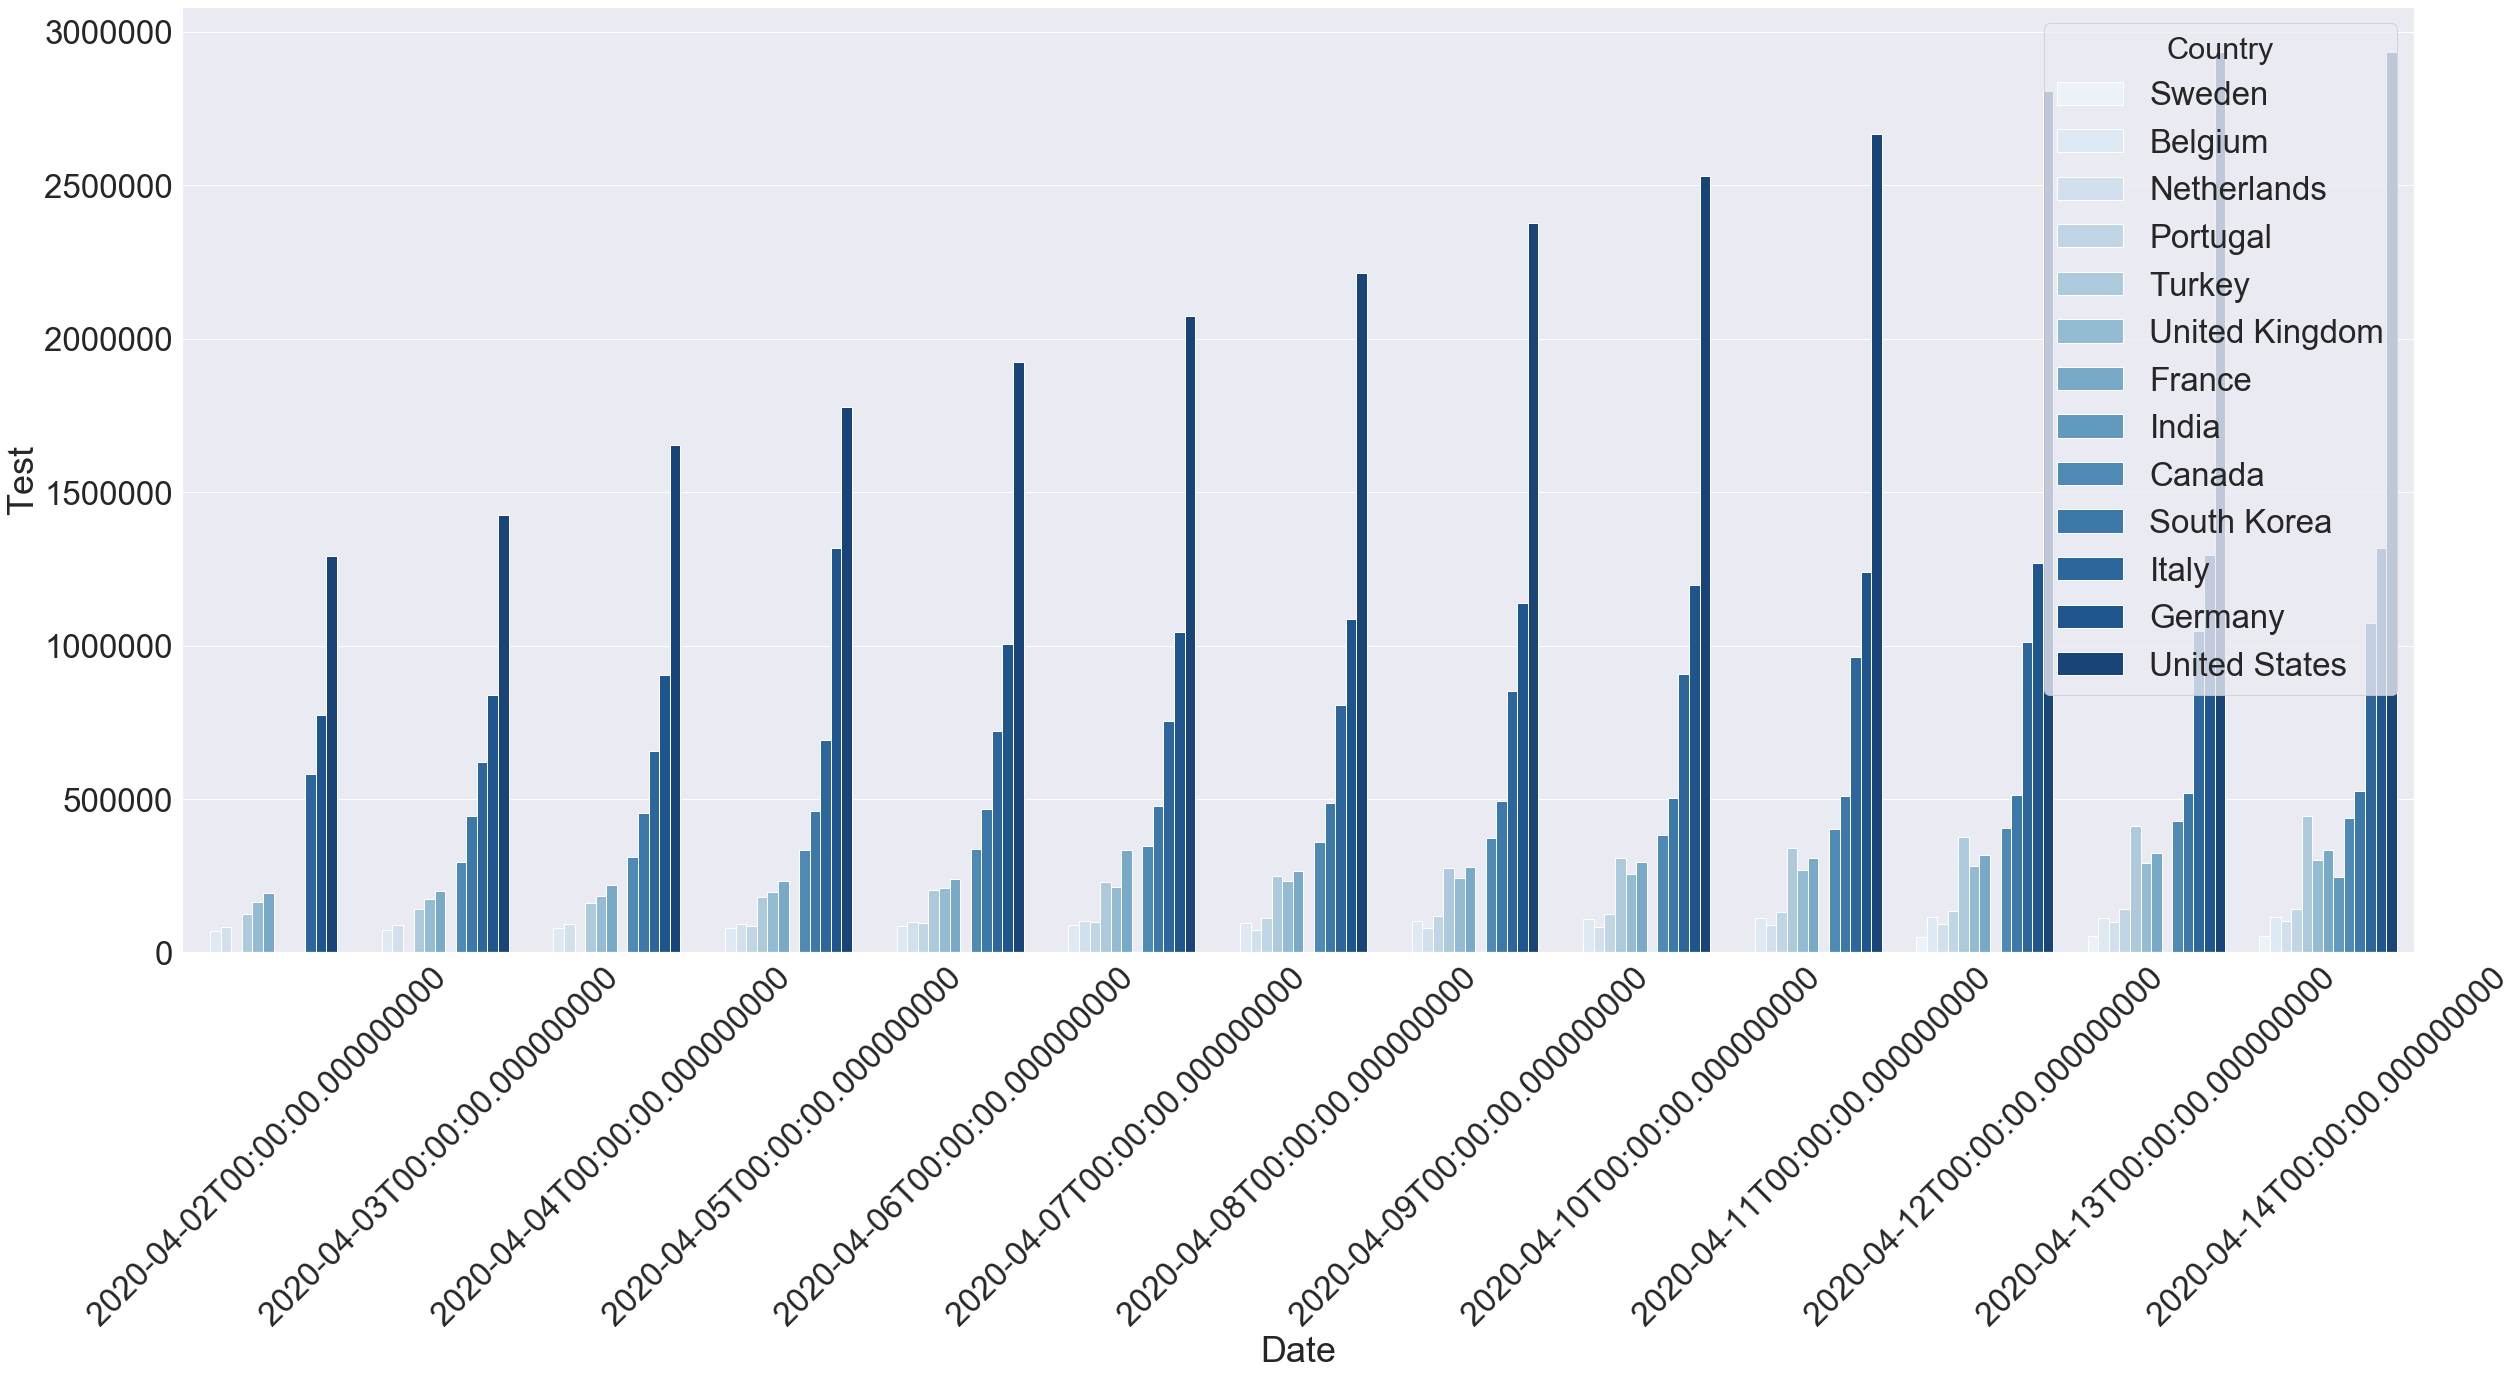

In [284]:
# Test numbers chart by country whho has more than 1 million populaiton and case number is above 10k.
sns.set(font_scale = 3)
plt.figure(figsize=(36,20))
ax = sns.barplot(x="Date",hue="Country", y="Test",palette="Blues", data=covid_new[(covid_new.Population>10000000) & (covid_new.Date>"2020-04-01") & (covid_new.Case>10000)].sort_values(by="Test"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
